In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from fbprophet import Prophet

import warnings
warnings.simplefilter('ignore', FutureWarning)
pd.options.mode.chained_assignment = None

In [2]:
energy_data = pd.read_csv('SimpleEnergyUsage.csv')

In [3]:
energy_data.head()

,Date,National Avg Temp (F),NG ($/MSCF),US Crude Price ($/BBL),Electricity ($/kWh),US Petroleum Products (Million Barrels),Electrical Generation (Billion Kilowatthours),U.S. Natural Usage (BCF)
0,1/1/1981,32.4,3.94,28.81,0.053,571.321,413.516410,1890
1,2/1/1981,34.5,3.99,34.30,0.055,475.689,359.719821,1702
2,3/1/1981,37.3,4.06,34.59,0.056,493.111,371.667764,1871
3,4/1/1981,41.7,4.11,33.92,0.056,460.490,345.682684,1808
4,5/1/1981,45.2,4.29,32.73,0.058,475.943,356.277107,1838


In [4]:
energy_data['Date']=pd.to_datetime(energy_data['Date'])
energy_data['ds']=energy_data['Date']
energy_data.tail()

,Date,National Avg Temp (F),NG ($/MSCF),US Crude Price ($/BBL),Electricity ($/kWh),US Petroleum Products (Million Barrels),Electrical Generation (Billion Kilowatthours),U.S. Natural Usage (BCF),ds
449,2018-06-01,49.4,16.51,62.80,0.142,621.160,743.661142,2955,2018-06-01
450,2018-07-01,53.1,17.92,67.00,0.143,639.261,823.648759,3108,2018-07-01
451,2018-08-01,55.7,18.63,62.64,0.142,660.371,819.962135,3180,2018-08-01
452,2018-09-01,57.0,17.32,63.55,0.142,598.542,712.675051,3135,2018-09-01
453,2018-10-01,56.7,12.26,65.18,0.137,643.980,649.800520,3273,2018-10-01


In [5]:
petroleum_data=energy_data[["ds","US Petroleum Products (Million Barrels)"]]
electrical_data=energy_data[["ds","Electrical Generation (Billion Kilowatthours)"]]
natgas_data=energy_data[["ds","U.S. Natural Usage (BCF)"]]

petroleum_data_training=petroleum_data[:-12]
electrical_data_training=electrical_data[:-12]
natgas_data_training=natgas_data[:-12]

#petroleum_data_training['y_orig'] = petroleum_data_training['US Petroleum Products (Million Barrels)']
#electrical_data_training['y_orig'] = electrical_data_training['Electrical Generation (Billion Kilowatthours)'] 
#natgas_data_training['y_orig'] = natgas_data_training['U.S. Natural Usage (BCF)'] 

# log-transform y
petroleum_data_training['y'] = np.log(petroleum_data_training['US Petroleum Products (Million Barrels)'])
electrical_data_training['y'] = np.log(electrical_data_training['Electrical Generation (Billion Kilowatthours)'])
natgas_data_training['y'] = np.log(natgas_data_training['U.S. Natural Usage (BCF)'])

In [6]:
petroleum_training_model = Prophet() #instantiate Prophet
electrical_training_model = Prophet()
natgas_training_model = Prophet()

petroleum_training_model.fit(petroleum_data_training); #fit the model with your dataframe
electrical_training_model.fit(electrical_data_training);
natgas_training_model.fit(natgas_data_training);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
validation_time = petroleum_training_model.make_future_dataframe(periods=12, freq = 'm')

petroleum_validation = petroleum_training_model.predict(validation_time)
electrical_validation = electrical_training_model.predict(validation_time)
natgas_validation = natgas_training_model.predict(validation_time)

In [8]:
petroleum_validation['yhat'] = np.exp(petroleum_validation['yhat'])
electrical_validation['yhat'] = np.exp(electrical_validation['yhat'])
natgas_validation['yhat'] = np.exp(natgas_validation['yhat'])

In [9]:
#from fbprophet.diagnostics import cross_validation
#from fbprophet.diagnostics import performance_metrics
#df_cv = cross_validation(petroleum_training_model, initial='7300 days', period='180 days', horizon = '365 days')
#df_p = performance_metrics(df_cv)
#df_p.head()

In [10]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
petroleum_compare=pd.concat([energy_data[-36:],petroleum_validation[-36:]], axis=1, sort=False)
print(f'Petroleum R2: {r2_score(petroleum_compare["US Petroleum Products (Million Barrels)"].iloc[:-12], petroleum_compare["yhat"].iloc[:-12])}')

electrical_compare=pd.concat([energy_data[-36:],electrical_validation[-36:]], axis=1, sort=False)
print(f'Electrical R2: {r2_score(electrical_compare["Electrical Generation (Billion Kilowatthours)"].iloc[:-12], electrical_compare["yhat"].iloc[:-12])}')

natgas_compare=pd.concat([energy_data[-36:],natgas_validation[-36:]], axis=1, sort=False)
print(f'Natural Gas R2: {r2_score(natgas_compare["U.S. Natural Usage (BCF)"].iloc[:-12], natgas_compare["yhat"].iloc[:-12])}')

Petroleum R2: 0.7485198794269978
Electrical R2: 0.9065891043419679
Natural Gas R2: 0.09340186874942547


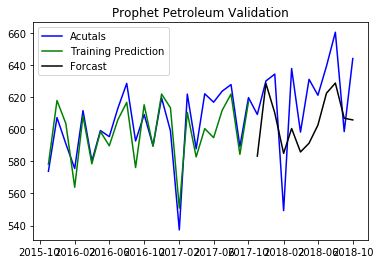

In [11]:
actuals, = plt.plot(petroleum_compare["Date"], petroleum_compare["US Petroleum Products (Million Barrels)"], color="blue", label="Acutals" )
model_fit, = plt.plot(petroleum_compare["Date"].iloc[:-12], petroleum_compare["yhat"].iloc[:-12], color="green",label='Training Prediction')
forcast, = plt.plot(petroleum_compare["Date"].iloc[-12:], petroleum_compare["yhat"].iloc[-12:], color="black",label='Forcast')

# Create a legend for our chart
plt.legend(handles=[actuals, model_fit,forcast], loc="best")
plt.title("Prophet Petroleum Validation")

# Show the chart
plt.savefig("Prophet_Petroleum_Validation.jpg")
plt.show()

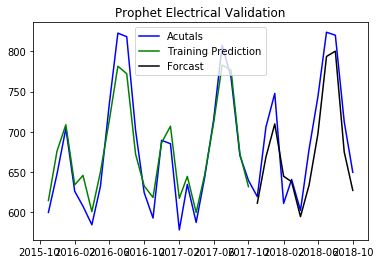

In [12]:
actuals, = plt.plot(electrical_compare["Date"], electrical_compare["Electrical Generation (Billion Kilowatthours)"], color="blue", label="Acutals" )
model_fit, = plt.plot(electrical_compare["Date"].iloc[:-12], electrical_compare["yhat"].iloc[:-12], color="green",label='Training Prediction')
forcast, = plt.plot(electrical_compare["Date"].iloc[-12:], electrical_compare["yhat"].iloc[-12:], color="black",label='Forcast')

# Create a legend for our chart
plt.legend(handles=[actuals, model_fit,forcast], loc="best")
plt.title("Prophet Electrical Validation")

# Show the chart
plt.savefig("Prophet_Electrical_Validation.jpg")
plt.show()

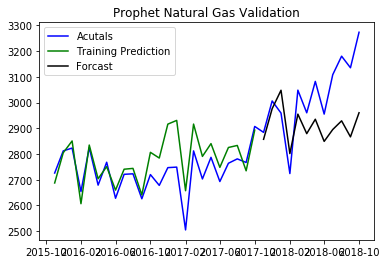

In [13]:
actuals, = plt.plot(natgas_compare["Date"], natgas_compare["U.S. Natural Usage (BCF)"], color="blue", label="Acutals" )
model_fit, = plt.plot(natgas_compare["Date"].iloc[:-12], natgas_compare["yhat"].iloc[:-12], color="green",label='Training Prediction')
forcast, = plt.plot(natgas_compare["Date"].iloc[-12:], natgas_compare["yhat"].iloc[-12:], color="black",label='Forcast')

# Create a legend for our chart
plt.legend(handles=[actuals, model_fit,forcast], loc="best")
plt.title("Prophet Natural Gas Validation")

# Show the chart
plt.savefig("Prophet_Natural_Gas_Validation.jpg")
plt.show()

In [14]:
petroleum_data['y'] = np.log(petroleum_data['US Petroleum Products (Million Barrels)'])
electrical_data['y'] = np.log(electrical_data['Electrical Generation (Billion Kilowatthours)'])
natgas_data['y'] = np.log(natgas_data['U.S. Natural Usage (BCF)'])

petroleum_model = Prophet() #instantiate Prophet
electrical_model = Prophet()
natgas_model = Prophet()

petroleum_model.fit(petroleum_data); #fit the model with your dataframe
electrical_model.fit(electrical_data);
natgas_model.fit(natgas_data);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
validation_time = petroleum_model.make_future_dataframe(periods=12, freq = 'm')

petroleum_forcast = petroleum_model.predict(validation_time)
electrical_forcast = electrical_model.predict(validation_time)
natgas_forcast = natgas_model.predict(validation_time)

In [16]:
petroleum_forcast['petroleum_forcast'] = np.exp(petroleum_forcast['yhat'])
electrical_forcast['electrical_forcast'] = np.exp(electrical_forcast['yhat'])
natgas_forcast['natgas_forcast'] = np.exp(natgas_forcast['yhat'])

In [17]:
forcasts = pd.concat([energy_data[['National Avg Temp (F)', 'NG ($/MSCF)',
       'US Crude Price ($/BBL)', 'Electricity ($/kWh)',
       'US Petroleum Products (Million Barrels)',
       'Electrical Generation (Billion Kilowatthours)',
       'U.S. Natural Usage (BCF)']],petroleum_forcast['petroleum_forcast'],electrical_forcast['electrical_forcast'],natgas_forcast['natgas_forcast'],natgas_forcast['ds']], axis=1, sort=False)

In [18]:
forcasts.to_csv('Prophet_Forcasts.csv')

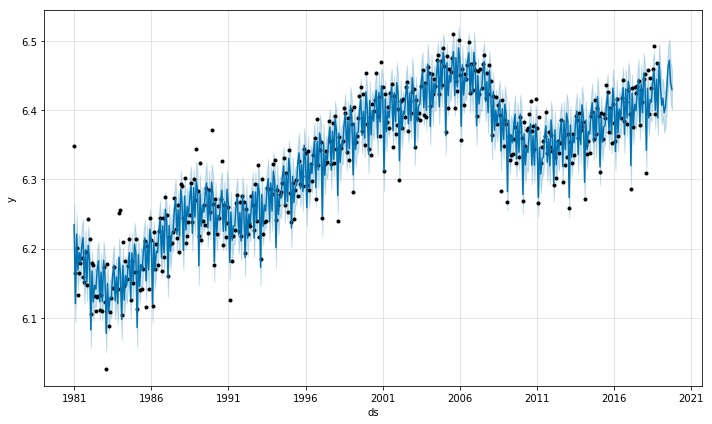

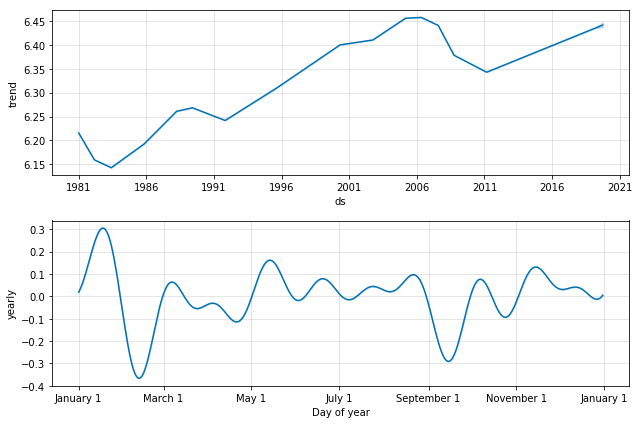

In [32]:
petroleum_model.plot(petroleum_forcast,uncertainty=True);
petroleum_model.plot_components(petroleum_forcast);

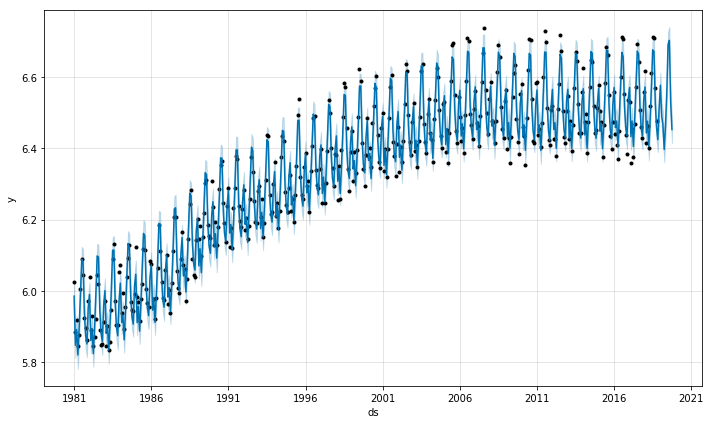

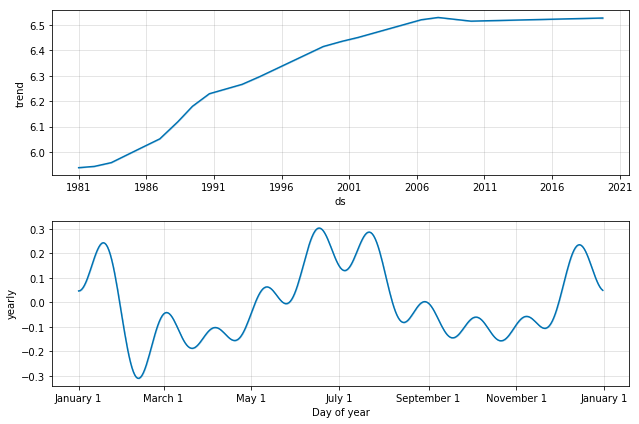

In [31]:
electrical_model.plot(electrical_forcast,uncertainty=True);
electrical_model.plot_components(electrical_forcast);

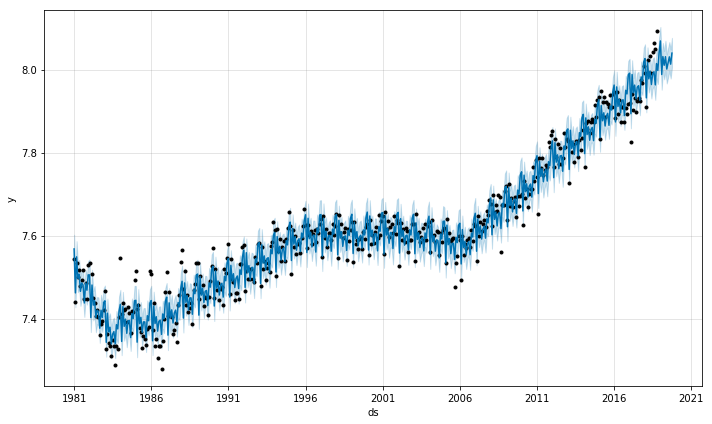

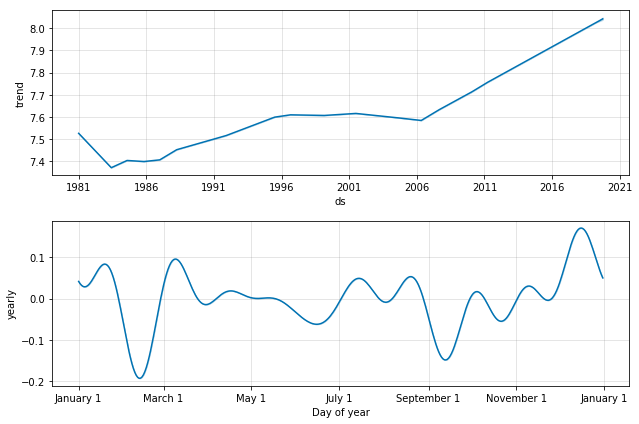

In [30]:
natgas_model.plot(natgas_forcast,uncertainty=True);
natgas_model.plot_components(natgas_forcast);